In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from pandas import DataFrame as df
from pandas import Series as se
import statsmodels.api as sm

In [32]:
df1=pd.read_excel('Online_Retail.xlsx')
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [33]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [34]:
df1=df1.dropna()

In [35]:
df1.describe()

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [36]:
df1=df1[df1['Quantity']>0]
df1=df1[df1['UnitPrice']>=0.01]

In [37]:
df1['Amount']=df1['Quantity']*df1['UnitPrice']

In [38]:
monetary=df1.groupby('CustomerID')['Amount'].agg('sum')

In [39]:
monetary.head()

CustomerID
12346.0    77183.60
12347.0     4310.00
12348.0     1797.24
12349.0     1757.55
12350.0      334.40
Name: Amount, dtype: float64

In [40]:
df2=df1[['CustomerID','InvoiceNo']]
df2=df2.drop_duplicates()

freq=df2.groupby('CustomerID')['InvoiceNo'].agg('count')
freq.head()

CustomerID
12346.0    1
12347.0    7
12348.0    4
12349.0    1
12350.0    1
Name: InvoiceNo, dtype: int64

In [41]:
max_dt=max(df1['InvoiceDate'])
max_dt

Timestamp('2011-12-09 12:50:00')

In [42]:
df1['rec']=max_dt-df1['InvoiceDate']
df1['rec']=df1['rec'].apply(lambda x: x.days)+1

In [43]:
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,rec
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,374
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,374
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,374
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,374
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,374


In [44]:
recency=df1.groupby('CustomerID')['rec'].agg('min')
recency.head()

CustomerID
12346.0    326
12347.0      2
12348.0     75
12349.0     19
12350.0    310
Name: rec, dtype: int64

In [45]:
RFM=pd.concat([recency,freq,monetary],join='inner',axis=1)

In [47]:
RFM.columns=['Recency','Frequency','Monetory']

In [48]:
RFM.head()

,Recency,Frequency,Monetory
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


In [17]:
RFM.columns

Index(['rec', 'InvoiceNo', 'Amount'], dtype='object')

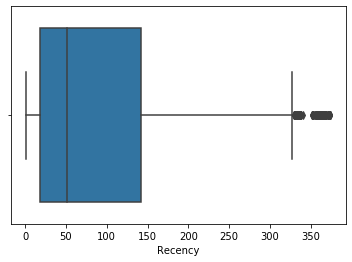

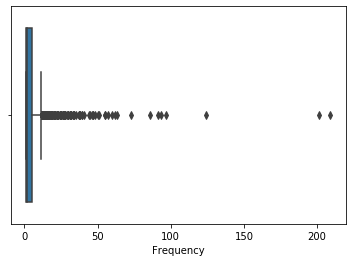

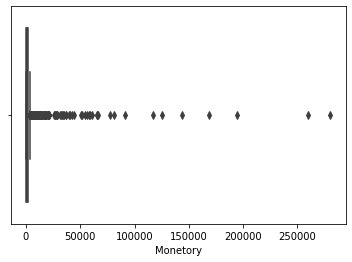

In [49]:
for i in RFM.columns:
    sns.boxplot(RFM[i])
    plt.show()

In [50]:
for i in RFM.columns:
    q1=np.percentile(RFM[i],25)
    q3=np.percentile(RFM[i],75)
    iqr=q3-q1
    ul=q3+(1.5*iqr)
    ll=q1-(1.5*iqr)
    RFM[RFM[i]>ul]=np.nan
    RFM[RFM[i]<ll]=np.nan

In [51]:
RFM=RFM.fillna(method='ffill')

# Segmenting Customers Based on RFM

In [52]:
from sklearn.preprocessing import StandardScaler
ss= StandardScaler()
RFMs=ss.fit_transform(RFM)

In [53]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
kmeans = KMeans()

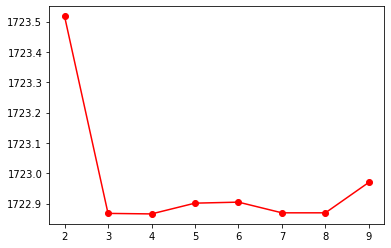

In [54]:
ssd=[]
ssc=[]
for k in range(2,10):
    kmean = KMeans(n_clusters=k,random_state=10)
    kmeans.fit(RFMs)
    ssd.append(kmeans.inertia_)
    labels=kmeans.labels_
    ssc.append(silhouette_score(RFMs,labels))
    
plt.plot(range(2,10),ssd,color='r',marker='o')
plt.show()

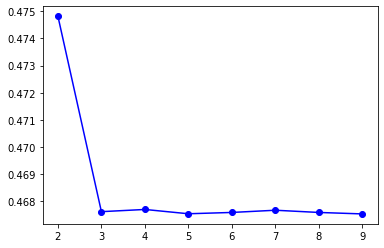

In [55]:
plt.plot(range(2,10),ssc,color='b',marker='o')
plt.show()

In [56]:
import plusmodules as pm

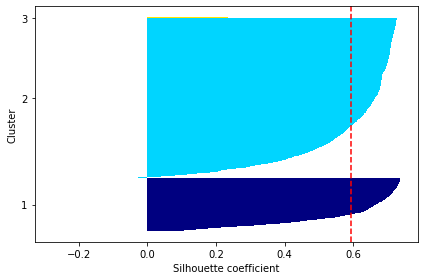

In [57]:
pm.svisualizer(RFMs,3)

In [58]:
kmeans = KMeans(n_clusters=3,random_state=10)
kmeans.fit(RFMs)

KMeans(n_clusters=3, random_state=10)

In [59]:
labels=kmeans.labels_

In [60]:
RFM['labels']=labels

In [61]:
RFM.groupby('labels').count()

,Recency,Frequency,Monetory
labels,,,
0,1073,1073,1073
1,3239,3239,3239
2,26,26,26


In [63]:
RFM.groupby('labels').mean()

,Recency,Frequency,Monetory
labels,,,
0,219.373719,1.691519,690.629031
1,38.277246,4.738808,1873.719555
2,6.038462,66.423077,85904.351538
